In [12]:
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [13]:
loader = DirectoryLoader('./', glob="./data/*.txt", loader_cls=TextLoader)
docs = loader.load()

In [14]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

In [15]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vectors = embeddings.embed_documents(doc_strings)

In [16]:
db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 6})

In [17]:
import umap
import numpy as np
from tqdm import tqdm

# Transform the vectors to 2D space in order to visualize them
umap_transformer = umap.UMAP(random_state=0, transform_seed=0).fit(vectors)

/Users/ttornkvi/git/Applied-Advanced-RAG/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ttornkvi/git/Applied-Advanced-RAG/venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [19]:
def umap_embed(vectors, umap_transformer):
    umap_embeddings = np.array([umap_transformer.transform([vector])[0] for vector in tqdm(vectors)])
    return umap_embeddings

In [20]:
global_embeddings = umap_embed(vectors, umap_transformer)

100%|██████████| 63/63 [00:19<00:00,  3.17it/s]


In [21]:
global_embeddings

array([[ 2.0519829 , 12.139986  ],
       [ 3.996203  , 11.994909  ],
       [ 1.7677892 , 11.842589  ],
       [ 2.2584333 ,  8.908635  ],
       [ 3.581199  , 10.953373  ],
       [ 3.5644355 , 11.003839  ],
       [ 2.8939853 ,  9.300886  ],
       [ 3.6973886 , 10.691899  ],
       [ 3.7314677 , 10.196327  ],
       [ 3.4138293 ,  9.564282  ],
       [ 1.7626733 , 11.886751  ],
       [ 1.1990553 ,  9.172759  ],
       [ 0.86329406, 10.5578575 ],
       [ 1.1167405 ,  9.20165   ],
       [ 1.6520175 , 11.607683  ],
       [ 3.005282  ,  9.366952  ],
       [ 2.924902  ,  9.327273  ],
       [ 2.6943426 ,  9.191279  ],
       [ 1.8638747 ,  8.871684  ],
       [ 1.8336364 , 11.980323  ],
       [ 1.117527  , 11.009085  ],
       [ 0.83655345, 10.468912  ],
       [ 2.3558247 , 12.3514    ],
       [ 0.71613425,  9.724524  ],
       [ 2.219228  , 12.22614   ],
       [ 3.593674  , 11.532198  ],
       [ 3.8692026 , 12.446893  ],
       [ 2.897856  , 12.396722  ],
       [ 2.9915624 ,

(-0.07541213333606722,
 17.338608303666113,
 6.3453819274902346,
 12.737440872192384)

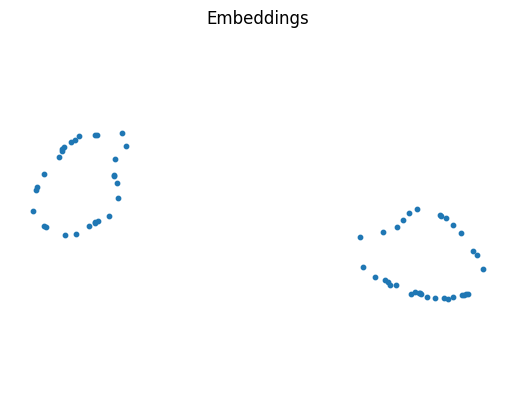

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Embeddings')
plt.axis('off')

In [23]:
def calc_global_embeddings(query, embeddings, retriever, umap_transformer, embed_function, global_embeddings):
    q_embedding = embeddings.embed_query(query)

    docs = retriever.get_relevant_documents(query)
    page_contents = [doc.page_content for doc in docs]
    vectors_content_vectors = embeddings.embed_documents(page_contents)

    query_embeddings = embed_function([q_embedding], umap_transformer)
    retrieved_embeddings = embed_function(vectors_content_vectors, umap_transformer)

    plt.figure()
    plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10, color='gray')
    plt.scatter(query_embeddings[:, 0], query_embeddings[:, 1], s=150, marker='X', color='r')
    plt.scatter(retrieved_embeddings[:, 0], retrieved_embeddings[:, 1], s=50, facecolors='none', edgecolors='g')
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{query}')
    plt.axis('off')
    plt.show()


/var/folders/cq/lhlr_ykn5l123vlq84c24fvm0000gn/T/ipykernel_89680/3242896288.py:4: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  docs = retriever.get_relevant_documents(query)
100%|██████████| 6/6 [00:01<00:00,  3.38it/s]


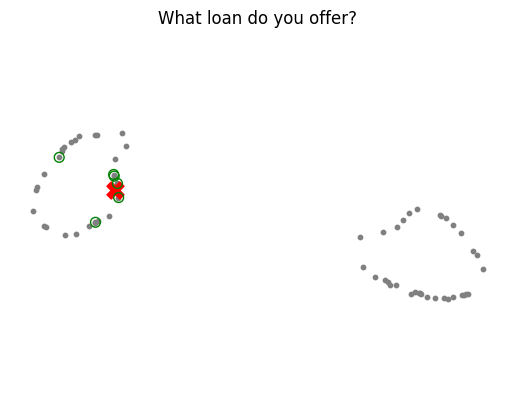

In [24]:
calc_global_embeddings("What loan do you offer?", embeddings, retriever, umap_transformer, umap_embed, global_embeddings)

100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


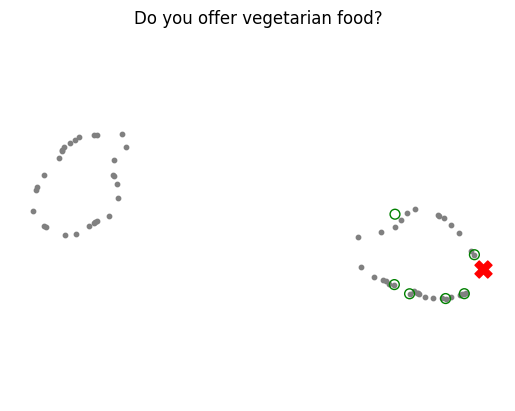

In [25]:
calc_global_embeddings("Do you offer vegetarian food?", embeddings, retriever, umap_transformer, umap_embed, global_embeddings)


### Query Expansion 

In [26]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
        temperature=0,
        max_tokens=800,
        #model_kwargs={"top_p": 0, "frequency_penalty": 0, "presence_penalty": 0},
        top_p=0,
        frequency_penalty=0,
        presence_penalty=0
    )

In [27]:
from langchain.schema.runnable import Runnable
from langchain_core.messages.ai import AIMessage

# Experiment with a Runnable that can convert a (list of) AIMessage objects to a list of strings
class AIMessageToString(Runnable):
    def invoke(self, input_messages, config):
        # Check if input_messages is a list
        if isinstance(input_messages, list):
            # Initialize an empty list to store content strings
            content_strings = []
            # Loop over each message in the list
            for message in input_messages:
                # Check if the message is a AIMessages instance
                if isinstance(message, AIMessage):
                    # Append the content string to the list
                    content_strings.append(message.content)
                else:
                    raise TypeError("Expected each item in the list to be a AIMessage object.")
            # Return the list of content strings
            return content_strings
        else:
            # Check if the message is just an AIMessages instance
            if isinstance(input_messages, AIMessage):
                # Return the content string
                return input_messages.content
            else:
                raise TypeError("Expected input_message to be a AIMessage object.")

In [28]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda

query = "Do you offer vegetarian food?"

def split_lines(text: str) -> list[str]:
    return text.strip().split("\n")

output_parser = AIMessageToString() | RunnableLambda(split_lines)

prompt = ChatPromptTemplate.from_template(
    """You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions separated by newlines. Only provide the query, no numbering.
    Original question: {question}""")

llm_chain = prompt | llm | output_parser
queries = llm_chain.invoke(query)
queries

['Do you provide plant-based meal options?',
 'Are vegetarian dishes available on your menu?',
 'Do you have any meatless food choices?',
 'Are there vegetarian-friendly options on your menu?',
 'Do you cater to customers looking for vegetarian meals?']

In [9]:
#queries = queries.get("text")
#queries

AttributeError: 'list' object has no attribute 'get'

In [30]:
docs = [retriever.get_relevant_documents(query) for query in queries]
docs

[[Document(metadata={'source': 'data/data2.txt'}, page_content='La Bella Vita also prides itself on its vegetarian and vegan options, catering to all dietary'),
  Document(metadata={'source': 'data/data2.txt'}, page_content='dietary preferences. Dishes like eggplant parmigiana and mushroom risotto are crafted with the same'),
  Document(metadata={'source': 'data/data2.txt'}, page_content='the same attention to detail and flavor as their meat-based counterparts.'),
  Document(metadata={'source': 'data/data2.txt'}, page_content='La Bella Vita also offers a unique dining experience with its private dining rooms and catering'),
  Document(metadata={'source': 'data/data2.txt'}, page_content='the restaurant provides a personalized service that makes every event memorable.'),
  Document(metadata={'source': 'data/data2.txt'}, page_content='cooking expertise to the table. The menu features a variety of regional specialties, showcasing the')],
 [Document(metadata={'source': 'data/data2.txt'}, pa

In [31]:
aset = set()
aset.add("foo")
aset.add("bar")
aset.add("baz")
print(aset)
aset.add("bar")
print(aset)

{'foo', 'baz', 'bar'}
{'foo', 'baz', 'bar'}


In [32]:
unique_contents = set()
unique_docs = []
for sublist in docs:
    for doc in sublist:
        if doc.page_content not in unique_contents:
            unique_docs.append(doc)
            unique_contents.add(doc.page_content)
unique_contents = list(unique_contents)

In [33]:
unique_contents

['La Bella Vita also prides itself on its vegetarian and vegan options, catering to all dietary',
 "catering services. Whether it's for a special occasion, a business meeting, or a family gathering,",
 'cooking expertise to the table. The menu features a variety of regional specialties, showcasing the',
 'dietary preferences. Dishes like eggplant parmigiana and mushroom risotto are crafted with the same',
 'La Bella Vita also offers a unique dining experience with its private dining rooms and catering',
 'the restaurant provides a personalized service that makes every event memorable.',
 'the same attention to detail and flavor as their meat-based counterparts.',
 'The pasta selection is a highlight of the menu, featuring classics like lasagna, ravioli, and',
 'from rich and creamy to light and zesty, are made with the freshest ingredients, bringing out the',
 'The meat and fish dishes are equally impressive, with offerings like osso buco, saltimbocca, and']

In [34]:
# This is a simpler way to get unique contents (?)
ucont = set()
for sublist in docs:
    for doc in sublist:
        ucont.add(doc.page_content)
ucont = list(ucont)
ucont

['La Bella Vita also prides itself on its vegetarian and vegan options, catering to all dietary',
 "catering services. Whether it's for a special occasion, a business meeting, or a family gathering,",
 'cooking expertise to the table. The menu features a variety of regional specialties, showcasing the',
 'dietary preferences. Dishes like eggplant parmigiana and mushroom risotto are crafted with the same',
 'La Bella Vita also offers a unique dining experience with its private dining rooms and catering',
 'the restaurant provides a personalized service that makes every event memorable.',
 'the same attention to detail and flavor as their meat-based counterparts.',
 'The pasta selection is a highlight of the menu, featuring classics like lasagna, ravioli, and',
 'from rich and creamy to light and zesty, are made with the freshest ingredients, bringing out the',
 'The meat and fish dishes are equally impressive, with offerings like osso buco, saltimbocca, and']

# Cross-encoder re-ranking

In [35]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/Users/ttornkvi/git/Applied-Advanced-RAG/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [36]:
pairs = []
for doc in unique_contents:
    pairs.append([query, doc])

In [37]:
scores = cross_encoder.predict(pairs)
scores

array([ -2.7005744, -11.167172 , -11.102643 ,  -9.750738 , -11.079877 ,
       -10.895903 , -10.356453 , -10.774686 , -10.663025 ,  -8.007283 ],
      dtype=float32)

In [38]:
scored_docs = zip(scores, unique_contents)
sorted_docs = sorted(scored_docs, reverse=True)
sorted_docs

[(-2.7005744,
  'La Bella Vita also prides itself on its vegetarian and vegan options, catering to all dietary'),
 (-8.007283,
  'The meat and fish dishes are equally impressive, with offerings like osso buco, saltimbocca, and'),
 (-9.750738,
  'dietary preferences. Dishes like eggplant parmigiana and mushroom risotto are crafted with the same'),
 (-10.356453,
  'the same attention to detail and flavor as their meat-based counterparts.'),
 (-10.663025,
  'from rich and creamy to light and zesty, are made with the freshest ingredients, bringing out the'),
 (-10.774686,
  'The pasta selection is a highlight of the menu, featuring classics like lasagna, ravioli, and'),
 (-10.895903,
  'the restaurant provides a personalized service that makes every event memorable.'),
 (-11.079877,
  'La Bella Vita also offers a unique dining experience with its private dining rooms and catering'),
 (-11.102643,
  'cooking expertise to the table. The menu features a variety of regional specialties, showca

In [40]:
reranked_docs = [doc for _, doc in sorted_docs][0:5]
reranked_docs

['La Bella Vita also prides itself on its vegetarian and vegan options, catering to all dietary',
 'The meat and fish dishes are equally impressive, with offerings like osso buco, saltimbocca, and',
 'dietary preferences. Dishes like eggplant parmigiana and mushroom risotto are crafted with the same',
 'the same attention to detail and flavor as their meat-based counterparts.',
 'from rich and creamy to light and zesty, are made with the freshest ingredients, bringing out the']

### Lost in the middle Problem

https://arxiv.org/abs/2307.03172

In [45]:
from langchain_community.document_transformers import (
    LongContextReorder
)

In [46]:
reordering = LongContextReorder()
reordered_docs = reordering.transform_documents(reranked_docs)
reordered_docs

['La Bella Vita also prides itself on its vegetarian and vegan options, catering to all dietary',
 'dietary preferences. Dishes like eggplant parmigiana and mushroom risotto are crafted with the same',
 'from rich and creamy to light and zesty, are made with the freshest ingredients, bringing out the',
 'the same attention to detail and flavor as their meat-based counterparts.',
 'The meat and fish dishes are equally impressive, with offerings like osso buco, saltimbocca, and']